# About Dataset

There are **5 columns** in the dataset, each are:

**1. Store ID:** (Index) ID of the particular store.

**2. Store_Area:** Physical Area of the store in yard square.

**3. Items_Available:** Number of different items available in the corresponding store.

**4. DailyCustomerCount:** Number of customers who visited to stores on an average over month.

**5. Store_Sales:** Sales in (US $) that stores made.

# Importing Libraries

In [1]:
# DataFrame
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

# Styling
%matplotlib inline
from termcolor import colored, cprint
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "cursive"

# Cluster & Visualization
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

# Models
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

# Preprocessing
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Reading data
df = pd.read_csv('../input/stores-area-and-sales-data/Stores.csv')

In [3]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [4]:
# Let's drop "Store ID" feature, because we won't use it
df = df.drop('Store ID ',axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store_Area            896 non-null    int64
 1   Items_Available       896 non-null    int64
 2   Daily_Customer_Count  896 non-null    int64
 3   Store_Sales           896 non-null    int64
dtypes: int64(4)
memory usage: 28.1 KB


In [6]:
df.describe()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000
mean,1485.409598,1782.035714,786.350446,59351.305804
std,250.237011,299.872053,265.389281,17190.741895
min,775.000000,932.000000,10.000000,14920.000000
25%,1316.750000,1575.500000,600.000000,46530.000000
50%,1477.000000,1773.500000,780.000000,58605.000000
75%,1653.500000,1982.750000,970.000000,71872.500000
max,2229.000000,2667.000000,1560.000000,116320.000000


### We will get from above describtion:

* The minimum store area is 775 and the biggest store area is 2229 yard per square meter.
* A store with minimum number of items is 932 and there is a store that has maximum of 2667 items available.
* Minimum number of customers that a store ever had was 10 and maximum was 1560 on average day over month.
* Minimum number of sales were 14920 and the maximum number of sales were 116320

In [7]:
# Let's see top 5 stores with highest sales

highest_sales = pd.DataFrame(df.nlargest(5, ['Store_Sales']))
highest_sales

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
649,1989,2414,860,116320
868,1775,2104,980,105150
432,1365,1638,680,102920
408,1303,1587,1310,102310
758,1486,1758,820,101820


In [8]:
# show the top 5 stores with lowest sales

lowest_sales = pd.DataFrame(df.nsmallest(5, ['Store_Sales']))
lowest_sales

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
31,1250,1508,990,14920
852,1477,1790,880,16370
775,1537,1877,660,17670
593,1624,1946,870,20270
352,1397,1686,850,21300


# EDA

<AxesSubplot:>

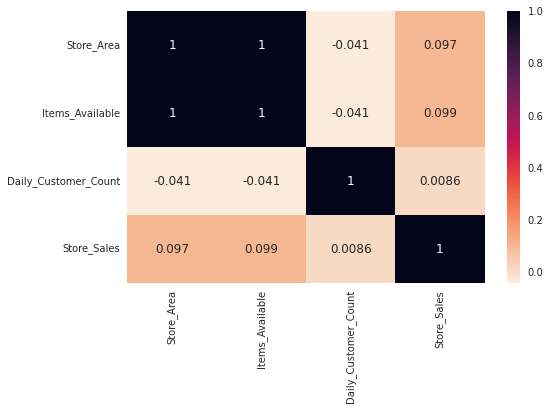

In [9]:
# Let's see the correlation between variables

plt.figure(figsize = (8, 5))
sns.heatmap(df.corr(), annot = True, cmap = 'rocket_r')

**We can notice from above heatmap:**
* Store area and items available has a linear relationship
* Store area and items available has more impact on store sales rather than daily customers

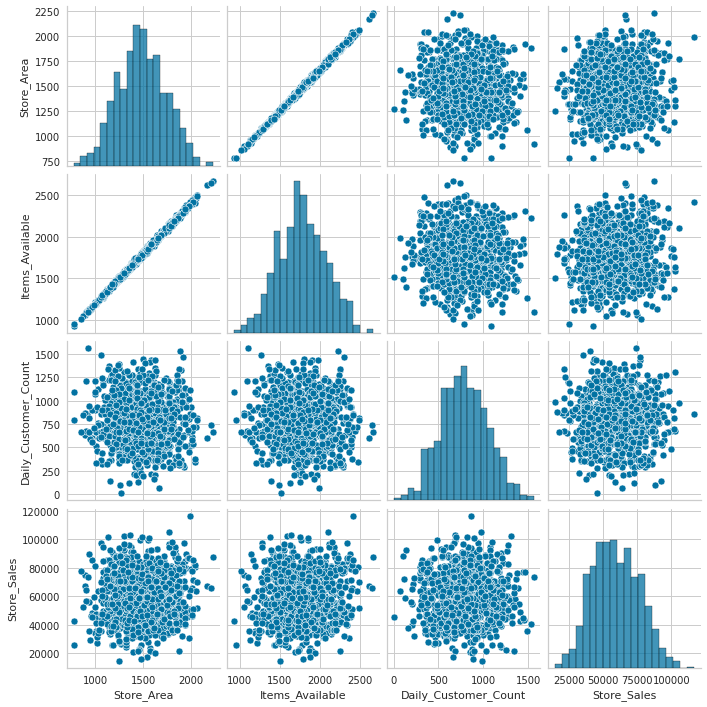

In [10]:
sns.pairplot(df)

**Notes:**
* We can see that the distribution of store area, items available, daily customers and store sales is almost **normal**.
* 'Items_Available' and 'Store_Area' has **high positive correlation**.

In [11]:
columns = df.columns.tolist()

fig = go.Figure()
fig.add_trace(go.Box(y=df[columns[0]], name=columns[0],
                marker_color = '#1589FF'))
fig.add_trace(go.Box(y=df[columns[1]], name = columns[1],
                marker_color = '#659EC7'))
fig.add_trace(go.Box(y=df[columns[2]], name = columns[2],
                marker_color = '#00BFFF'))

fig.update_layout(
    font=dict(size=19,family="Franklin Gothic"),
    template='simple_white',
    title = 'Features (BoxPlot)')
fig.show()

In [12]:
fig = go.Figure()
fig.add_trace(go.Box(y=df[columns[3]], name=columns[3],
                marker_color = '#B0CFDE'))

fig.update_layout(
    font=dict(size=19,family="Franklin Gothic"),
    template='simple_white',
    title = 'Target Column (BoxPlot)')
fig.show()

**We noticed that there are outliers!**

# Feature Engineering

### Remove outliers from features

In [13]:
columns = df.columns.tolist()

# To remove outliers in features
def remove_outliers(column):
    idx = []
    Q1 = np.percentile(column, 25, interpolation = 'midpoint')
    Q3 = np.percentile(column, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    upper = np.where(column >= (Q3+1.5*IQR))
    lower = np.where(column <= (Q1-1.5*IQR))
    column = column.drop(upper[0])
    column = column.drop(lower[0])
    return column

In [14]:
# To merge dataframe with series
def create_new_dataframe(dataframe):
    lst = []
    columns = df.columns.tolist()[:-1]
    for column in columns:
        lst.append(remove_outliers(df[column]))
    return pd.concat(lst,axis=1).dropna()

In [15]:
df  = pd.concat([create_new_dataframe(df),df['Store_Sales']], axis=1).dropna().reset_index().drop('index',axis=1)

df.tail()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
883,1582.0,1910.0,1080.0,66390
884,1387.0,1663.0,850.0,82080
885,1200.0,1436.0,1060.0,76440
886,1299.0,1560.0,770.0,96610
887,1174.0,1429.0,1110.0,54340


In [16]:
# Check if there are another outliers
fig = go.Figure()
fig.add_trace(go.Box(y=df[columns[0]], name=columns[0],
                marker_color = '#1589FF'))
fig.add_trace(go.Box(y=df[columns[1]], name = columns[1],
                marker_color = '#659EC7'))
fig.add_trace(go.Box(y=df[columns[2]], name = columns[2],
                marker_color = '#00BFFF'))

fig.update_layout(
    font=dict(size=19,family="Franklin Gothic"),
    template='simple_white',
    title = 'Features (BoxPlot)')
fig.show()

**Now, There is no outliers!**

# Data Preprocessing

In [17]:
y = df['Store_Sales']
X = df.drop('Store_Sales',axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42) 

In [19]:
sc = StandardScaler()
X = sc.fit_transform(X)

# Modeling before clustering

## Random Forest Regressor

In [20]:
rfr = RandomForestRegressor(bootstrap = True, max_depth = 90, max_features = 2, min_samples_leaf = 4, min_samples_split = 12, n_estimators = 100)
rfr.fit(X_train, y_train)
r_pred = rfr.predict(X_test)

In [21]:
mse = mean_squared_error(y_test, r_pred)
rmse = np.sqrt(mean_squared_error(y_test, r_pred))
mae = mean_absolute_error(y_test, r_pred)

score = rfr.score(X_train, y_train) 
scores = cross_val_score(rfr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(rfr, X_train, y_train, cv=kfold )

In [22]:
print('RandomForest Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

RandomForest Regressor
MSE: 338376052.44
RMSE: 18395.00
MAE: 15346.16
Training score:  0.4212849181791304
Mean cross-validation score: -0.05
K-fold CV average score: -0.07


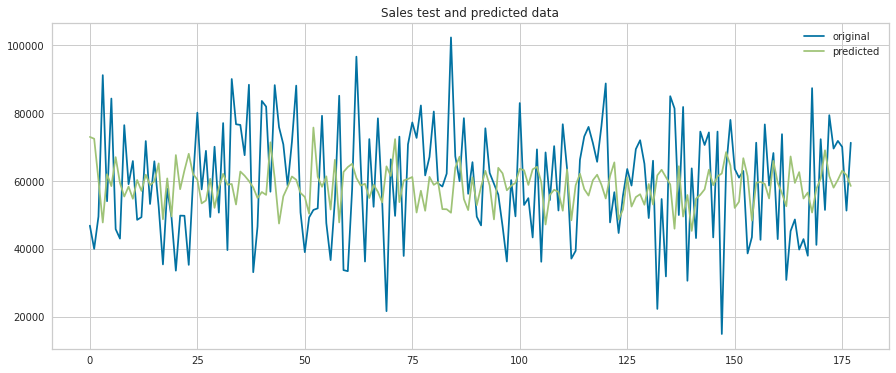

In [23]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, r_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

# Data Mining

We will find the ratio of store area , items and customers to know the purchasing power of a particular store For that we will make a copy of the orfiginal dataset

In [24]:
sales_data_avgs = df.copy()
sales_data_avgs.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1659.0,1961.0,530.0,66490
1,1461.0,1752.0,210.0,39820
2,1340.0,1609.0,720.0,54010
3,1451.0,1748.0,620.0,53730
4,1770.0,2111.0,450.0,46620


In [25]:
sales_data_avgs['ratio_items/cutomers'] = sales_data_avgs['Items_Available']/sales_data_avgs['Daily_Customer_Count']
sales_data_avgs['ratio_size/customers'] = sales_data_avgs['Store_Area']/sales_data_avgs['Daily_Customer_Count']
sales_data_avgs['ratio_size/items']     = sales_data_avgs['Store_Area']/sales_data_avgs['Items_Available']
sales_data_avgs['target_sales'] = df['Store_Sales']

In [26]:
sales_data_avgs.drop(['Store_Area','Items_Available','Daily_Customer_Count','Store_Sales'],axis = 1, inplace = True)
sales_data_avgs.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,target_sales
0,3.700000,3.130189,0.845997,66490
1,8.342857,6.957143,0.833904,39820
2,2.234722,1.861111,0.832815,54010
3,2.819355,2.340323,0.830092,53730
4,4.691111,3.933333,0.838465,46620


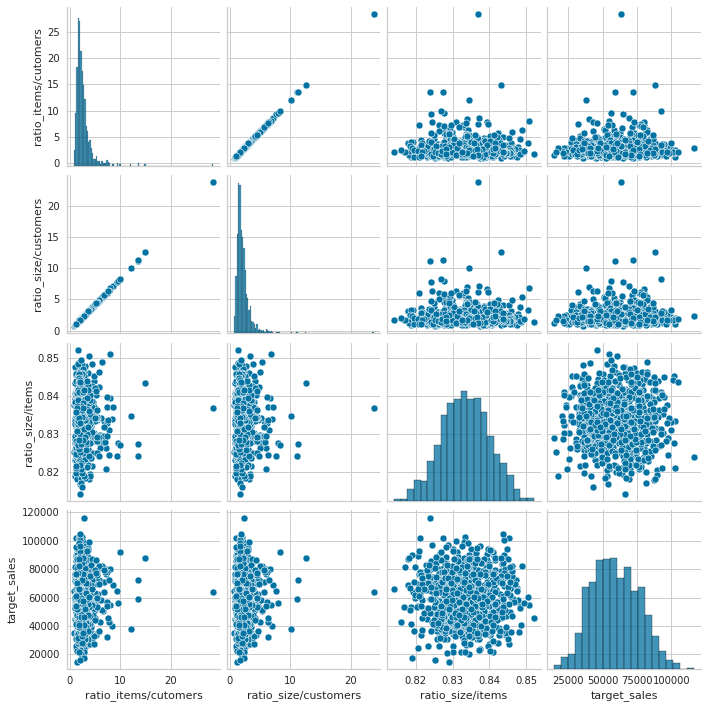

In [27]:
sns.pairplot(data = sales_data_avgs)

Text(0, 0.5, 'Inertia')

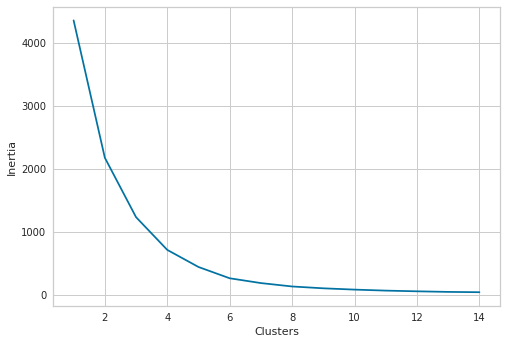

In [28]:
x= sales_data_avgs.drop('target_sales',axis= 1)
clusters = []

for i in range(1, 15):
    km = KMeans(n_clusters=i).fit(x)
    clusters.append(km.inertia_)
    
sns.lineplot(x=list(range(1, 15)), y=clusters)
plt.xlabel('Clusters')
plt.ylabel('Inertia')

We learned from the graph above, that the data can be grouped into 10 different groups to classify it for purchasing power of customers

In [29]:
km_10 = KMeans(n_clusters=10).fit(X)
x['Labels'] =km_10.labels_
x.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Labels
0,3.700000,3.130189,0.845997,3
1,8.342857,6.957143,0.833904,3
2,2.234722,1.861111,0.832815,7
3,2.819355,2.340323,0.830092,7
4,4.691111,3.933333,0.838465,0


In [30]:
y = sales_data_avgs['target_sales']

Creating group for target sales based on labels


In [31]:
sales_join = x.join(y)
sales_join.columns

Index(['ratio_items/cutomers', 'ratio_size/customers', 'ratio_size/items',
       'Labels', 'target_sales'],
      dtype='object')

Text(0, 0.5, 'Inertia')

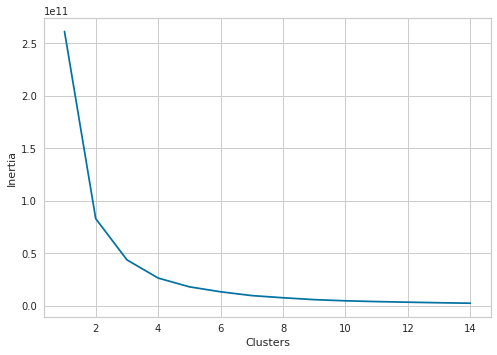

In [32]:
sales_x = sales_join[['Labels','target_sales']]

x1= sales_x
clusters = []

for i in range(1, 15):
    km = KMeans(n_clusters=i).fit(x1)
    clusters.append(km.inertia_)
    
sns.lineplot(x=list(range(1, 15)), y=clusters)
plt.xlabel('Clusters')
plt.ylabel('Inertia')

In [33]:
km_10 = KMeans(n_clusters=10).fit(x1)
x['Target_Groups'] =km_10.labels_
x.head()

,ratio_items/cutomers,ratio_size/customers,ratio_size/items,Labels,Target_Groups
0,3.700000,3.130189,0.845997,3,4
1,8.342857,6.957143,0.833904,3,0
2,2.234722,1.861111,0.832815,7,8
3,2.819355,2.340323,0.830092,7,8
4,4.691111,3.933333,0.838465,0,5


# Modeling after clustering

[1]  Used **6 models** with 10 FOLD cross validation for model comparison:

1.  LinearRegression
1.  DecisionTreeRegressor
1.  XGBRegressor
1.  LGBMRegressor
1.  CatBoostRegressor
1.  RandomForestRegressor

[2] Used StandardScaler() for scaling.

[3] Evaluation metrics: **mae**, **mse**, **rmse**, **R2_score**

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42) 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42) 

## 1-Linear Regression


In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred =lr.predict(X_test)

In [36]:
mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
mae = mean_absolute_error(y_test, lr_pred)

score = lr.score(X_train, y_train) 
scores = cross_val_score(lr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(lr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  lr_pred)

In [37]:
print('Linear Regression')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

Linear Regression
MSE: 263932119.32
RMSE: 16245.99
MAE: 13664.33
Training score:  0.013544537252329736
Mean cross-validation score: -0.00
K-fold CV average score: -0.02
R_score : 0.03


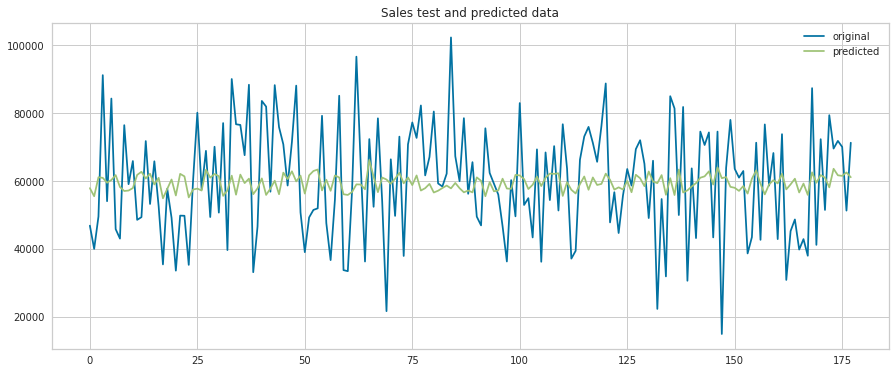

In [38]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, lr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

## 2-Decision Tree Regressor

In [39]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr_pred =dtr.predict(X_test)

In [40]:
mse = mean_squared_error(y_test, dtr_pred)
rmse = np.sqrt(mean_squared_error(y_test, dtr_pred))
mae = mean_absolute_error(y_test, dtr_pred)

score = dtr.score(X_train, y_train) 
scores = cross_val_score(dtr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(dtr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  dtr_pred)

In [41]:
print('DecisionTree Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

DecisionTree Regressor
MSE: 11448029.21
RMSE: 3383.49
MAE: 2675.17
Training score:  1.0
Mean cross-validation score: 0.96
K-fold CV average score: 0.96
R_score : 0.96


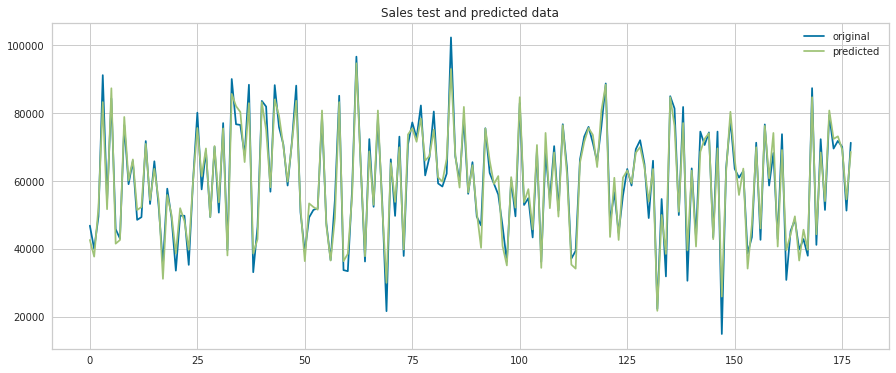

In [42]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, dtr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

## 3-XGB Regressor

In [43]:
xgbr = XGBRegressor(random_state = 116)
xgbr.fit(X_train, y_train)
xgbr_pred =xgbr.predict(X_test)

In [44]:
mse = mean_squared_error(y_test, xgbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgbr_pred))
mae = mean_absolute_error(y_test, xgbr_pred)

score = xgbr.score(X_train, y_train) 
scores = cross_val_score(xgbr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  xgbr_pred)

In [45]:
print('XGB Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

XGB Regressor
MSE: 8561645.79
RMSE: 2926.03
MAE: 2200.80
Training score:  0.9997259937607198
Mean cross-validation score: 0.97
K-fold CV average score: 0.97
R_score : 0.97


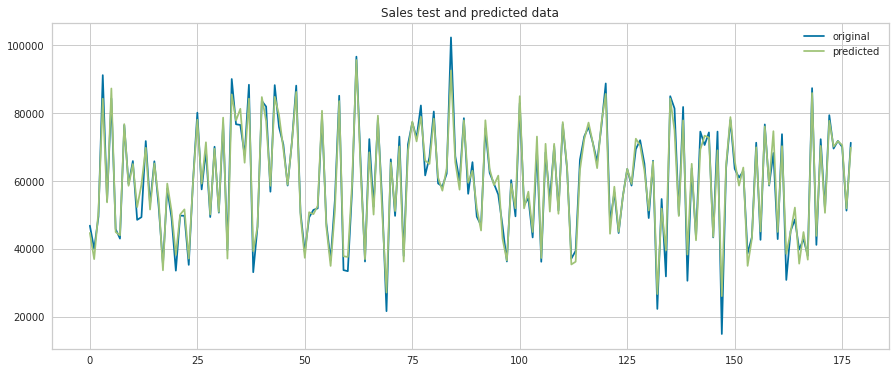

In [46]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, xgbr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

## 4-LGBM Regressor

In [47]:
lgbr = lgb.LGBMRegressor(random_state = 116)
lgbr.fit(X_train, y_train)
lgbr_pred =lgbr.predict(X_test)

In [48]:
mse = mean_squared_error(y_test, lgbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, lgbr_pred))
mae = mean_absolute_error(y_test, lgbr_pred)

score = lgbr.score(X_train, y_train) 
scores = cross_val_score(lgbr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(lgbr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  lgbr_pred)

In [49]:
print('LGBM Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

LGBM Regressor
MSE: 6590401.26
RMSE: 2567.18
MAE: 2029.53
Training score:  0.9924601473430833
Mean cross-validation score: 0.97
K-fold CV average score: 0.97
R_score : 0.98


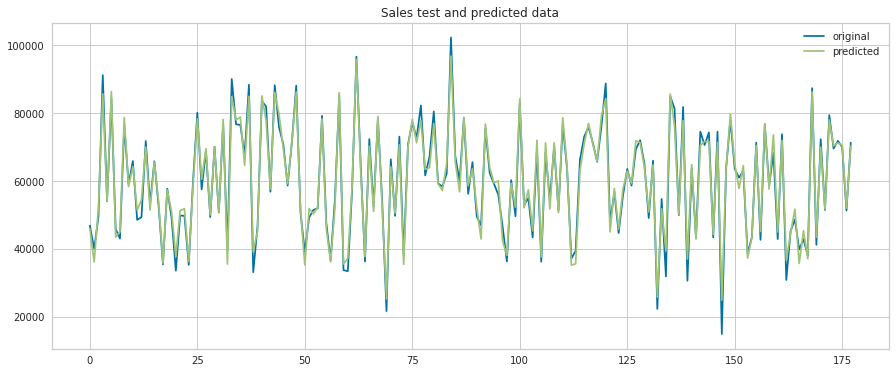

In [50]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, lgbr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

## 5-CatBoost Regressor

In [51]:
cbr = CatBoostRegressor(random_state =116, verbose = 0)
cbr.fit(X_train, y_train)
cbr_pred =cbr.predict(X_test)

In [52]:
mse = mean_squared_error(y_test, cbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, cbr_pred))
mae = mean_absolute_error(y_test, cbr_pred)

score = cbr.score(X_train, y_train) 
scores = cross_val_score(cbr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(cbr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  cbr_pred)

In [53]:
print('CatBoost Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

CatBoost Regressor
MSE: 7894644.75
RMSE: 2809.74
MAE: 2150.63
Training score:  0.9947971239836353
Mean cross-validation score: 0.98
K-fold CV average score: 0.98
R_score : 0.97


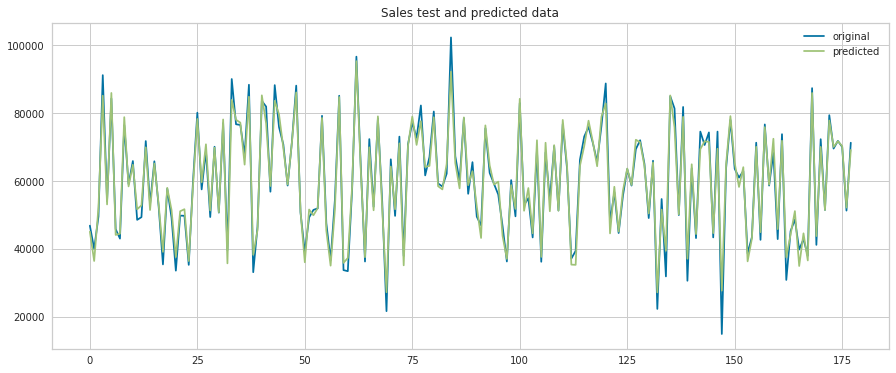

In [54]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, cbr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

## 6-Random Forest Regressor

In [55]:
rf = RandomForestRegressor(random_state = 116)
rf.fit(X_train, y_train)
rf_pred =rf.predict(X_test)

In [56]:
mse = mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
mae = mean_absolute_error(y_test, rf_pred)

score = rf.score(X_train, y_train) 
scores = cross_val_score(rf, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(rf, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  rf_pred)

In [57]:
print('Random Forest Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

Random Forest Regressor
MSE: 6451311.81
RMSE: 2539.94
MAE: 1982.88
Training score:  0.9965442946128501
Mean cross-validation score: 0.98
K-fold CV average score: 0.98
R_score : 0.98


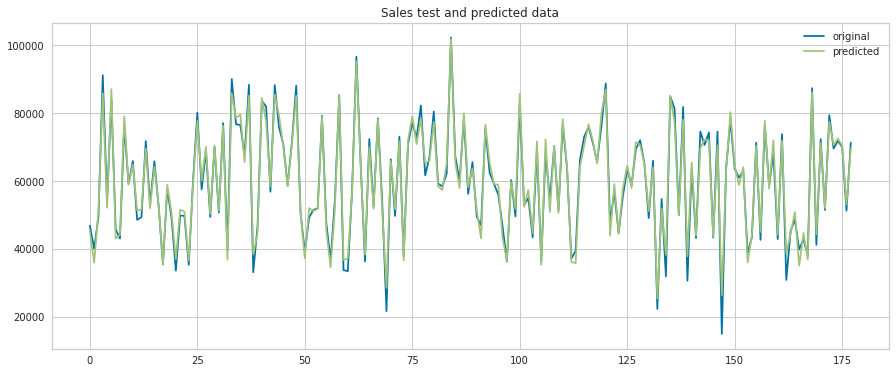

In [58]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rf_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

In [59]:
# parameters
class PARAM:
    FOLD = 10
    RANDOM_STATE = 116
    VERBOSE = 0
    
# scaling function
def Scaler(train_X, val_X):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_X)
    scaled_val = scaler.transform(val_X)
    return scaled_train, scaled_val

# define models
xgbr = XGBRegressor(random_state = PARAM.RANDOM_STATE)
lgbr = lgb.LGBMRegressor(random_state = PARAM.RANDOM_STATE)
cbr = CatBoostRegressor(random_state = PARAM.RANDOM_STATE, verbose = PARAM.VERBOSE)
rf = RandomForestRegressor(random_state = PARAM.RANDOM_STATE)
dtr = DecisionTreeRegressor()
lr = LinearRegression()

classifiers_name = ['XGBRegressor','LGBMRegressor','CatBoostRegressor','RandomForestRegressor','DecisionTreeRegressor','LinearRegression']
color_sequence = ['red','blue','green','grey','cyan','yellow']
classifiers = [xgbr, lgbr, cbr, rf, dtr, lr]
mae_score = []
mse_score = []
rmse_score = []
R2_score = []

fold = KFold(n_splits=PARAM.FOLD, shuffle=True, random_state=PARAM.FOLD)

# 10 fold
for idx, classifier in enumerate(classifiers):
    mae = 0  
    mse = 0
    rmse = 0
    r2score = 0
    print(colored('Classifier:',color_sequence[idx]) ,colored(classifiers_name[idx],color_sequence[idx]), '\n\n')
    for fold_idx, (train_idx, val_idx) in enumerate(fold.split(X, y)):
        
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        x_train, x_val = Scaler(x_train, x_val)
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = classifier.fit(x_train, y_train)
        val_preds = model.predict(x_val)
        
        mae += mean_absolute_error(y_val, val_preds) / PARAM.FOLD
        mse += mean_squared_error(y_val,val_preds) / PARAM.FOLD
        rmse += np.sqrt(mean_squared_error(y_val, val_preds)) / PARAM.FOLD
        r2score += r2_score(y_val,val_preds)/PARAM.FOLD
        
        print('Fold','{',fold_idx+1,'} ','\n\n')
        print('MAE Score: ', mean_absolute_error(y_val, val_preds))
        print('MSE Score: ', mean_squared_error(y_val,val_preds))
        print('RMSE Score: ', np.sqrt(mean_squared_error(y_val, val_preds)))
        print('R2 Score: ', r2_score(y_val,val_preds),'\n\n')
        
    mae_score.append(round(mae,2))
    mse_score.append(round(mse,2))
    rmse_score.append(round(rmse,2))
    R2_score.append(round(r2score,2))
    print('---'*20,'\n')

Classifier: XGBRegressor 


Fold { 1 }  


MAE Score:  2104.495062324438
MSE Score:  6791046.450066255
RMSE Score:  2605.963631762012
R2 Score:  0.975013063221514 


Fold { 2 }  


MAE Score:  2085.754827949438
MSE Score:  8115849.030289897
RMSE Score:  2848.8329242498403
R2 Score:  0.970087671021351 


Fold { 3 }  


MAE Score:  2085.8354327598313
MSE Score:  7049392.349248179
RMSE Score:  2655.0691797480868
R2 Score:  0.9744723359382326 


Fold { 4 }  


MAE Score:  2106.40276070927
MSE Score:  6541470.83629501
RMSE Score:  2557.629925594203
R2 Score:  0.9772980182371102 


Fold { 5 }  


MAE Score:  2353.5649139747193
MSE Score:  11945569.650466662
RMSE Score:  3456.236341812675
R2 Score:  0.9649828610012847 


Fold { 6 }  


MAE Score:  1884.021637991573
MSE Score:  5501778.181286329
RMSE Score:  2345.5869587986563
R2 Score:  0.9831521368066172 


Fold { 7 }  


MAE Score:  1987.1142687851125
MSE Score:  6354738.520076409
RMSE Score:  2520.8606705005354
R2 Score:  0.980949696851869

# Model Comparison

### Compare **R2 Score** of 5 regression models below:

In [60]:
fig = px.bar(x = classifiers_name,
             y = R2_score,
             text = R2_score,
             template = "simple_white",
             color = classifiers_name,
             color_discrete_sequence = px.colors.qualitative.Antique)

fig.update_layout(template = 'simple_white', title = 'R2 Score Comparison')

fig.update_layout(
    xaxis_title="Models",
    yaxis_title="R2_Score",
    font = dict(size=17, family = 'Franklin Gothic'))


fig.data[2].marker.line.width = 3
fig.data[2].marker.line.color='black'
    
fig.show()

### Our **'CatBoostRegressor'** model got the highest **R2_Score**.

**And RMSE Score Comparison:**

In [61]:
fig = px.line(x = classifiers_name,
             y = rmse_score,
             text = rmse_score,
             template = "simple_white",)

fig.update_layout(template = 'simple_white', title = 'RMSE Score Comparison')

fig.update_layout(
    xaxis_title="Models",
    yaxis_title="RMSE_Score",
    font = dict(size=17, family = 'Franklin Gothic'))

fig.show()

## Thanks You :)
Please **upvote** if you like this notebook !